In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import data_processing as dp
from scipy import signal
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import pywt
import os
import time
import h5py
from itertools import combinations

In [4]:
# read file name of data with various Labels
df = pd.read_csv('./useful_data_label.csv',index_col=0) 
# read file name of data with only label 0
df2 = pd.read_csv('./unuseful_data_label.csv',index_col=0)
# read some of the data with only label 0
df3 = pd.read_csv('./data/file_name.txt',header=None)

In [5]:
def mean_smooth(data,neighbor=5):
    [m,n,l]=data.shape
    temp = np.zeros((m,n+neighbor*2,l))
    temp[:,neighbor:-neighbor,:]=data
    results = np.zeros((m,n,l))
    for i in range(neighbor*2+1):
        results += temp[:,i:n+i,:]
    return results/(neighbor*2+1)

In [57]:
# read the data and labels of df2 or df3
sc = StandardScaler()
#sc = MinMaxScaler()
ind = df2.iloc[1].isna()
#files = np.concatenate([np.array(df.columns),np.array('正常/'+df2.columns[ind])])
files = np.array(df.columns)
N = len(files)
#sc = StandardScaler(with_mean=False)
width = 256
stride = 64
start = time.time()
i = 0
X = []
Y = []
X2 = []
Y2 = []
F = []
F2 = []
for file in files:
    #if file in np.array(df3.loc[:,0]):
    #    continue
    i += 1
    emg_data = pd.read_csv('./data/'+file)
    #emg_data.iloc[:,3:] = 
    emg_data = emg_data.dropna().reset_index(drop=True)
    #emg_data.iloc[:,3:]=normalize(emg_data.iloc[:,3:])
    #emg_data.iloc[:,3:] = sc.fit_transform(emg_data.iloc[:,3:])
    fn = 20
    wn=2*fn/1000
    fn1 = 350
    wn1 = 2*fn1/1000
    #b, a = signal.butter(4, [wn,wn1], 'bandpass')
    b, a = signal.butter(4, [wn], 'highpass')
    #for j in ['LEFT_TA','LEFT_TS','LEFT_BF','LEFT_RF','RIGHT_TA','RIGHT_TS','RIGHT_BF','RIGHT_RF']:
        #emg_data.loc[:,j] = signal.filtfilt(b, a, emg_data.loc[:,j])
    x,y = dp.generate_window_slide_data(emg_data,width=width,
                                        stride=stride,
                                        scaler=True,
                                        same_label=True)
    #x_r=np.abs(x)
    #x_r=mean_smooth(x_r,5)
    #x=np.concatenate([x,x_r],axis=2)
    #x=dp.lowpass_filter(x,300)
    ind1 = []
    ind2 = []
    l = len(y)
    for j in set(y):
        ind = np.where(y == j)[0].tolist()
        l_t = len(ind)
        ind1 += ind[:int(l_t*0.8)]
        ind2 += ind[int(l_t*0.8):]
        #l_t = len(label[ind])
        #feature1 += feature[ind][:int(l_t*0.8)].tolist()
        #label1 += label[ind][:int(l_t*0.8)].tolist()
        #feature2 += feature[ind][int(l_t*0.8):].tolist()
        #label2 += label[ind][int(l_t*0.8):].tolist()
    l1 = len(ind1)
    l2 = len(ind2)

    fi = [file]*len(x)
    X += x[ind1].tolist()
    Y += y[ind1].tolist()
    F += fi
    X2 += x[ind2].tolist()
    Y2 += y[ind2].tolist()
    F2 += fi
    print('%d/%d: '%(i,N)+file)
X=np.array(X)
X2=np.array(X2)
Y=np.array(Y)
Y2=np.array(Y2)
end = time.time()
duration = end-start
print('Duration: %f'%(duration))

1/21: G04_FoG_trial_1_emg.csv
2/21: G04_FoG_trial_2_emg.csv
3/21: G06_FoG_trial_1_emg.csv
4/21: G06_FoG_trial_2_emg.csv
5/21: G06_FoG_trial_3_emg.csv
6/21: G07_Freezing_Trial1_trial_1_emg.csv
7/21: G08_FoG_1_trial_1_emg.csv
8/21: G08_FoG_2_trial_1_emg.csv
9/21: G11_FoG_trial_1_emg.csv
10/21: G11_FoG_trial_2_emg.csv
11/21: P379_M050_2_OFF_A_FoG_trial_1_emg.csv
12/21: P379_M050_2_OFF_A_FoG_trial_2_emg.csv
13/21: P379_M050_2_OFF_A_FoG_trial_3_emg.csv
14/21: P379_M050_2_OFF_B_FoG_trial_1_emg.csv
15/21: P379_M050_2_OFF_B_FoG_trial_2_emg.csv
16/21: P379_M050_2_OFF_B_FoG_trial_3_emg.csv
17/21: P551_M050_2_A_FoG_trial_1_emg.csv
18/21: P551_M050_2_B_FoG_trial_1_emg.csv
19/21: P551_M050_2_B_FoG_trial_2_emg.csv
20/21: P812_M050_2_B_FoG_trial_1_emg.csv
21/21: P812_M050_2_B_FoG_trial_2_emg.csv
Duration: 30.698292


In [9]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers,Model,callbacks,regularizers,models
from sklearn.model_selection import train_test_split,cross_validate
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder,normalize,MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE,BorderlineSMOTE,ADASYN,SVMSMOTE
from tensorflow.compat.v1 import spectral

In [2]:
tf.executing_eagerly()

True

In [55]:
def train_model(model,feature,y,binary=True,file=None):
    if binary:
        ind = ((y==0)|(y==1)|(y==2)|(y==6))
        #ind1 = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
        y_01 = y[ind].copy()
        ind1 = ((y_01==1)|(y_01==2)|(y_01==6))
        y_01[ind1] = 1
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:1,1:5}
    else:
        ind = ((y==1)|(y==2)|(y==6))
        #ind = ((y==1)|(y==6))
        y_01 = y[ind].copy()
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:5,1:1,2:1}#{0:2,1:1,2:10,3:2}
    x_full,x_test,y_full,y_test = train_test_split(np.array(feature)[ind,:],y_01,
                                                   test_size=0.2,
                                                   random_state=123,
                                                   shuffle=True)
    x_train,x_valid,y_train,y_valid = train_test_split(x_full,y_full,
                                                       test_size=0.25,
                                                       random_state=555,
                                                       shuffle=True)
    

    x_train = x_full
    
    early_stopping = callbacks.EarlyStopping(patience = 20,
                                             monitor = 'val_loss', 
                                             restore_best_weights=True)
    history = model.fit(x_train,y_full,validation_data=(x_test,y_test),
                        epochs=100,batch_size=32,class_weight=cw,
                        #callbacks=[early_stopping],
                        shuffle=True)
    
    if binary:
        y_pred_t=model.predict(x_test)
        test = metrics.accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1))
        #test = metrics.accuracy_score(y_test,y_pred_t>0.5)
        
        #y_pred_v=model.predict(x_valid)
        #valid = metrics.accuracy_score(y_valid,np.argmax(y_pred_v,axis=1))
        y_pred_ta=model.predict(x_train)
        train = metrics.accuracy_score(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1))
        #train = metrics.accuracy_score(y_full,y_pred_ta>0.5)
        
        print('train: \n',metrics.confusion_matrix(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1)))
        #print('valid: \n',metrics.confusion_matrix(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1)))
        print('test: \n',metrics.confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1)))
        
        #print('train: \n',metrics.confusion_matrix(y_full,y_pred_ta>0.5))
        #print('test: \n',metrics.confusion_matrix(y_test,y_pred_t>0.5))

    else:
        y_pred_t=model.predict(x_test)
        test = metrics.accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1))
        #y_pred_v=model.predict(x_valid)
        #valid = metrics.accuracy_score(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1))
        y_pred_ta=model.predict(x_train)
        train = metrics.accuracy_score(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1))        
        print('train: \n',metrics.confusion_matrix(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1)))
        #print('valid: \n',metrics.confusion_matrix(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1)))
        print('test: \n',metrics.confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1)))
    print('test:%f'%test)
    #print('valid:%f'%valid)
    print('train:%f'%train)
    if file != None:
        model.save_model(file)
    return train,test

def test_model(model,feature,y,binary=True):
    if binary:
        ind = ((y==0)|(y==1)|(y==2)|(y==3)|(y==4)|(y==6))
        #ind1 = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
        y_01 = y[ind].copy()
        ind1 = ((y_01==1)|(y_01==2)|(y_01==6))
        y_01[ind1] = 1
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:1,1:5}
    else:
        ind = ((y==1)|(y==2)|(y==6))
        #ind = ((y==1)|(y==6))
        y_01 = y[ind].copy()
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:5,1:1,2:1}#{0:2,1:1,2:10,3:2}

    #print(y_01)
    #feature=sc.transform(feature[ind])
    feature = feature[ind]
    #feature=pca.transform(feature)
    y_pred=model.predict(feature)
    test = metrics.accuracy_score(np.argmax(y_01,axis=1),np.argmax(y_pred,axis=1))
    #test = metrics.accuracy_score(y_01,y_pred>0.5)
    
    print('acc:%f'%test)
    print(metrics.confusion_matrix(np.argmax(y_01,axis=1),np.argmax(y_pred,axis=1)))
    #print(metrics.confusion_matrix(y_01,y_pred>0.5))
    return test

def sparse_cost_sensitive_loss (y_true,y_pred):
    #cost_matrix = tf.constant([[0,1.,1,1.],
    #              [2,0,5,5],
    #              [1,1,0,1],
    #              [1.,2.,1,0]])
    cost_matrix = tf.constant([[0,2.,2],
                  [1,0,1],
                  [1.0,1.,0]])
    #cost_matrix = tf.constant([[0,1.],
    #              [5.,0]])
    batch_cost_matrix = tf.nn.embedding_lookup(cost_matrix, tf.argmax(y_true,axis=1))
    eps = 1e-6
    probability = tf.clip_by_value(y_pred, eps, 1-eps)
    cost_values = tf.math.log(1-probability)*batch_cost_matrix
    loss = tf.reduce_mean(-tf.reduce_sum(cost_values, axis=1))
    return loss

def rfft_layer(data):
    #data=layers.Reshape((data.shape[1],data.shape[2],1))(data)
    n = data.shape[2]
    #print(data.shape)
    for i in range(n):
        if i == 0:
            fft = K.abs(tf.signal.rfft(data[:,:,i]))
            fft = K.reshape(fft,(-1,fft.shape[1],1))
        else:
            temp = K.abs(tf.signal.rfft(data[:,:,i]))
            temp = K.reshape(temp,(-1,temp.shape[1],1))
            fft = K.concatenate([fft,temp],axis=2)
    #print(fft.shape)
    return fft

In [68]:
input_ = layers.Input(shape=[256,8])
#input_r = layers.Reshape((256*8,1))(input_)
fft = layers.Lambda(rfft_layer,name='fft')(input_)
#fft = layers.Concatenate(axis=0)(fft)
#print(fft.shape)
#fft_abs = layers.Lambda(K.abs,name='fft_abs')(fft)
lstm1 = layers.LSTM(50,return_sequences=True)(fft)
#drop1 = layers.Dropout(0.2)(lstm1)
lstm2 = layers.LSTM(50,return_sequences=True)(lstm1)
#drop2 = layers.Dropout(0.2)(lstm2)
#lstm3 = layers.LSTM(50,return_sequences=True)(drop2)
#drop3 = layers.Dropout(0.2)(lstm3)
lstm4 = layers.LSTM(50)(lstm2)
#drop4 = layers.Dropout(0.2)(lstm4)
#dense1 = layers.Dense(64,activation='relu')(drop4)
#drop5 = layers.Dropout(0.2)(dense1)
#dense2 = layers.Dense(32,activation='relu')(drop5)
#flat = layers.Flatten()(fft)
output = layers.Dense(3,activation='softmax')(lstm4)
model = Model(inputs=[input_],outputs=[output])

In [69]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [70]:
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 8)]          0         
_________________________________________________________________
fft (Lambda)                 (None, 129, 8)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 129, 50)           11800     
_________________________________________________________________
lstm_13 (LSTM)               (None, 129, 50)           20200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 153       
Total params: 52,353
Trainable params: 52,353
Non-trainable params: 0
_________________________________________________

In [71]:
train,test,sc = train_model(model,X,Y,False)

Epoch 1/100
213/213 [==============================] - 28s 131ms/step - loss: 0.7510 - accuracy: 0.6712 - val_loss: 0.7018 - val_accuracy: 0.7001
Epoch 2/100
213/213 [==============================] - 26s 122ms/step - loss: 0.6797 - accuracy: 0.6938 - val_loss: 0.6663 - val_accuracy: 0.7060
Epoch 3/100
213/213 [==============================] - 28s 130ms/step - loss: 0.6795 - accuracy: 0.7001 - val_loss: 0.6843 - val_accuracy: 0.6878
Epoch 4/100
213/213 [==============================] - 28s 132ms/step - loss: 0.6573 - accuracy: 0.7035 - val_loss: 0.6808 - val_accuracy: 0.6784
Epoch 5/100
213/213 [==============================] - 28s 132ms/step - loss: 0.6438 - accuracy: 0.7089 - val_loss: 0.6475 - val_accuracy: 0.6978
Epoch 6/100
213/213 [==============================] - 31s 146ms/step - loss: 0.6308 - accuracy: 0.7155 - val_loss: 0.6471 - val_accuracy: 0.7036
Epoch 7/100
213/213 [==============================] - 31s 144ms/step - loss: 0.6247 - accuracy: 0.7202 - val_loss: 0.6483 -

KeyboardInterrupt: 

In [56]:
test_model(model,X2,Y2,binary=False)

acc:0.669155
[[196 167 113]
 [201 817  59]
 [ 77  92 421]]


0.6691553896406907

In [58]:
model2=Model(inputs=model.input,outputs=model.get_layer('fft').output)

In [59]:
temp=model2.predict(X)

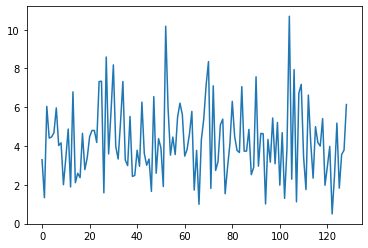

In [67]:
plt.plot(temp[150,:,6])

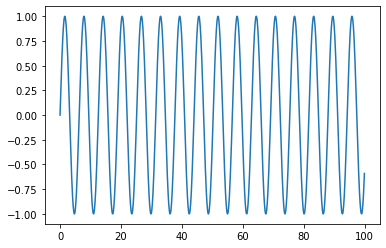

In [96]:
t = np.arange(0,100,0.1)
sin = np.sin(t)
plt.plot(t,sin)

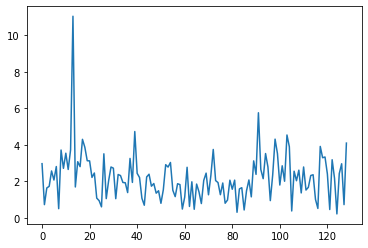

In [145]:
fft = tf.signal.rfft(X[:,:,0])
fft = np.abs(fft)
plt.plot(fft[50,:])

In [148]:
np.array(fft.tolist()+fft2.tolist()).shape

(25724, 129)

In [196]:
a = np.array([[1,2,3]])
b=np.array([[2,3,4]])
a.shape

(1, 3)

In [197]:
np.concatenate([a,b])

array([[1, 2, 3],
       [2, 3, 4]])

In [18]:
X.shape

(12862, 256, 8)